In [1]:
!pip -q install tweepy pandas nltk emoji spacy
!pip install seaborn wordcloud
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 8.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import tweepy

import pandas as pd

from dataclasses import dataclass
from typing import List

import re
import emoji

import spacy


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_

[nltk_data] Downloading package stopwords to /Users/TL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extract Tweets

In [4]:
CONSUMER_KEY = 'lIL92w9yLylrBTuv0His2sBlC'
CONSUMER_SECRET = 'RYLFTIXZkB5YQBCtRWtqnBLMZ11CE3OyfdoNJ4QMUkPY5Eb0Ne'
ACCESS_TOKEN = '1435410232604184581-w4ZXNCQqXwBs7xGNJD5cmDUsOkSxjv'
ACCESS_TOKEN_SECRET = 'Hx8VmvgLsI33bUHIOPc2k4LvybpSTPczs9hIUbppTd1O2'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True)
api.verify_credentials()

User(_api=<tweepy.api.API object at 0x1870d3850>, _json={'id': 1435410232604184581, 'id_str': '1435410232604184581', 'name': 'aaaaaa', 'screen_name': 'aaaaaa82502990', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 0, 'listed_count': 0, 'created_at': 'Wed Sep 08 01:10:53 +0000 2021', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 0, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_link_color':

In [7]:
class TweetScraper:
    
    def __init__(self):
        self.tweets = []
    
    def scrape_tweets(self, query: str, num_tweets: int)->List[Tweet]:
        num_tweets_found = 0
        for status in tweepy.Cursor(api.search, q=query, lang="en", tweet_mode='extended').items(num_tweets):
            # Exit condition
            if num_tweets_found >= num_tweets:
                break

            # Get tweet data
            s = status._json
            self.tweets.append(s)
            num_tweets_found+=1

In [8]:
tweet_scraper = TweetScraper()
tweet_scraper.scrape_tweets('Certified Lover Boy -filter:retweets', 10)

In [15]:
tweet_scraper.tweets[0]['geo']

{'type': 'Point', 'coordinates': [30.4391, -84.2836]}

In [16]:
tweet_scraper.tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [10]:
# Convert to dataframe
df = pd.DataFrame(tweet_scraper.tweets)
df

,created_at,id,id_str,full_text,truncated,display_text_range,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,Sat Oct 16 15:36:03 +0000 2021,1449398744445685763,1449398744445685763,@champagnepapi ain’t the only certified lover ...,False,"[0, 146]","{'hashtags': [{'text': 'zaddy', 'indices': [71...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1,Sat Oct 16 15:32:07 +0000 2021,1449397752115482632,1449397752115482632,@Drake I know this some time after but this Ce...,False,"[0, 194]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
2,Sat Oct 16 15:23:39 +0000 2021,1449395620528201735,1449395620528201735,Certified boy lover https://t.co/fAFD8VCMpe,False,"[0, 19]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1,1,False,False,False,en,1.449385e+18,1449385379791097860,{'created_at': 'Sat Oct 16 14:42:57 +0000 2021...,NaN
3,Sat Oct 16 15:19:37 +0000 2021,1449394607989592070,1449394607989592070,@whoisthiswao Certified lover boy 😝,False,"[14, 35]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.449362e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,Sat Oct 16 15:15:23 +0000 2021,1449393541675896840,1449393541675896840,dark lane demo tapes &gt;&gt;&gt; certified lo...,False,"[0, 53]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
5,Sat Oct 16 15:03:12 +0000 2021,1449390477657182211,1449390477657182211,certified boy lover,False,"[0, 19]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
6,Sat Oct 16 15:02:41 +0000 2021,1449390344005582855,1449390344005582855,@falineishereex1 Drake's certified lover boy.....,False,"[17, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.449388e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
7,Sat Oct 16 15:00:46 +0000 2021,1449389864932331522,1449389864932331522,@wavyusukev2 scary hours 2 is 2/3 while certif...,False,"[13, 105]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.449375e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
8,Sat Oct 16 15:00:02 +0000 2021,1449389680454082569,1449389680454082569,Drake's coming for Travis! ⚡️ The NOCTA x Nike...,False,"[0, 164]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,12,False,False,False,en,NaN,NaN,NaN,"{'media': [{'id': 1447568249219059719, 'id_str..."
9,Sat Oct 16 14:57:01 +0000 2021,1449388921255759876,1449388921255759876,Certified Lover Boy😎🙃 https://t.co/02xPoAd7HW,False,"[0, 21]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,1,False,False,False,en,NaN,NaN,NaN,"{'media': [{'id': 1449388900867321857, 'id_str..."


In [ ]:
df.to_csv("tweets.csv", sep="|", encoding='utf-8', index=False)

# Load tweets from file


In [68]:
df = pd.read_csv("tweets.csv", sep="|")
df

,date,handle,text
0,Sat Oct 16 11:13:53 +0000 2021,OVOXO_KekeG,Gets better every listen ❤️ https://t.co/P9GDm...
1,Sat Oct 16 11:07:06 +0000 2021,OfficialSpycee,@Troubulmaker1 @Wizebaba Na guy like you be th...
2,Sat Oct 16 11:04:37 +0000 2021,WavinR,@Ghenghis8 @BottleOfScrumpe Certified Boy Love...
3,Sat Oct 16 11:03:15 +0000 2021,heyyygelo,Certified Lover Boy lmaoooo https://t.co/mSLwA...
4,Sat Oct 16 10:55:40 +0000 2021,mandzsibiya,But then again ke he is a ‘Certified Lover Boy...
...,...,...,...
1902,Thu Oct 07 13:30:47 +0000 2021,InvinciblesWrld,"My Top 5 Albums this year so far, W or L \n\n1..."
1903,Thu Oct 07 13:12:29 +0000 2021,strngloves,certified lover boy by drake 🙏🏻💯 https://t.co/...
1904,Thu Oct 07 13:11:25 +0000 2021,LastOfDaReal94_,Certified Lover Boy I’m not the one for cuddli...
1905,Thu Oct 07 13:07:42 +0000 2021,LilRadbod,this mf drake woke up one day and decided to c...


# Text Cleaning and Preprocessing

In [82]:
# Search terms
# May contain n-grams
keywords = {
    "certified lover boy",
    "#certifiedloverboy"
    "clb",
    "#clb",
    'certified',
    'lover',
    'boy',
    'drake'
}


# Build stopwords set
# SOURCE: https://www.english-grammar-revolution.com/list-of-interjections.html
interjections = {
    "aha", "ahem", "ahh", "ahoy","alas", "aw", "bam",
    "bingo", "blah", "boo", "brr", "dang", "eh", "uhh",
    "phew", "shh", "fuck", "ugh", "yikes", "yo", "uh-oh",
    "uh-huh", "whoa", "whoops", "wow", "oops", "oh", "ouch",
    "hmm", "huh", "hey", "sheesh",
}

# Add interjections to stopwords
stop = set(stopwords_.words('english'))
stop = stop.union(interjections)
stop.add('be')


In [83]:
def clean_text(text: str, stopwords:set, keywords:set)-> str:
    """Clean text.
    Note: keywords may contain n-grams.
    """
    text = text.lower()
    
    # Remove search keywords
    for kw in keywords:
        text = re.sub(kw, '', text)
    
    text = re.sub(r'@[^\s]+','', text) # Remove twitter handles (e.g. "@elonmusk"
    text = re.sub(r'([^A-Za-z0-9_ \t])|(\w+:\/\/\S+)', '', text) # Remove non-alphanumeric characters/special characters

    text = re.sub(r"http\S.*$"," ", text) # Remove urls
    text = emoji.get_emoji_regexp().sub("", text)   # Remove emojis
    

    # Remove stopwords
    text = [word for word in text.split() if word not in stopwords]
    text = " ".join(text)
    
    text = re.sub('\s\s+', ' ', text) # Remove consecutive whitespaces
    text = text.strip()   # Remove trailing and leading whitespaces
    
    return text

def preprocess_text(text: str, nlp, stopwords:set=set(), keywords:set=set())->List[str]:
    """Clean, tokenize, and lemmatize the text."""
    text = clean_text(text, stopwords=stopwords, keywords=keywords)
    
    # Tokenize, lemmatize
    tokens = []
    doc = nlp(text)
    for token in doc:
      if token.lemma_ != '-PRON-':
        tokens.append(token.lemma_.lower())
    return tokens

In [84]:
nlp = spacy.load("en_core_web_sm")
cleaned_df = df.copy()
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: preprocess_text(text, nlp=nlp,stopwords=stop, keywords=keywords))
cleaned_df

,date,handle,text
0,Sat Oct 16 11:13:53 +0000 2021,OVOXO_KekeG,"[get, well, every, listen]"
1,Sat Oct 16 11:07:06 +0000 2021,OfficialSpycee,"[na, guy, like, real]"
2,Sat Oct 16 11:04:37 +0000 2021,WavinR,[ass]
3,Sat Oct 16 11:03:15 +0000 2021,heyyygelo,[lmaoooo]
4,Sat Oct 16 10:55:40 +0000 2021,mandzsibiya,"[ke, expect]"
...,...,...,...
1902,Thu Oct 07 13:30:47 +0000 2021,InvinciblesWrld,"[top, 5, albums, year, far, w, l, 1, call, get..."
1903,Thu Oct 07 13:12:29 +0000 2021,strngloves,[]
1904,Thu Oct 07 13:11:25 +0000 2021,LastOfDaReal94_,"[be, one, cuddle, none]"
1905,Thu Oct 07 13:07:42 +0000 2021,LilRadbod,"[mf, woke, one, day, decide, call, album, god,..."


Export Tweets into cleaned_tweets.csv file (For Checking)



In [85]:
cleaned_df.to_csv("cleaned_tweets.csv", encoding='utf-8', index=False)

# Text Analysis

## TFIDF 

In [86]:
def tweets_to_tfidf(tweets):
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [87]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [88]:
tweet_List = []
for index, row in cleaned_df.iterrows():
  tweet_List.append(' '.join(str(word) for word in row["text"]))

In [89]:
tfidf, vectorizer = tweets_to_tfidf(tweet_List)

In [90]:
print('TFIDF matrix shape:', tfidf.toarray().shape)
print(vectorizer.get_feature_names())

TFIDF matrix shape: (1907, 2000)
['01', '08', '10', '100', '100000', '100k', '100k2', '1010', '110000', '111k', '11bn', '12', '1265000', '13', '14', '15', '1579000', '16', '175', '190000', '19th', '1bn', '1st', '20', '200', '200chart', '2020', '2021', '20211', '2022', '20th', '21', '22', '23', '24kgoldn', '2k22', '2nd', '30', '34', '410', '50', '5th', '60', '600k', '65000', '6ixx', '6ixx_slab', '6th', '710', '72', '810', '95k', '97000', '9star', 'absolutely', 'academy', 'accidentally', 'accord', 'act', 'actual', 'actually', 'ada', 'add', 'adele', 'admit', 'age', 'ago', 'agree', 'aim', 'ak', 'aka', 'akademiks', 'album', 'albums', 'albums1', 'alexa', 'alive6', 'all', 'almost', 'alone', 'along', 'already', 'alright', 'also', 'always', 'amazing', 'amen', 'amp', 'another', 'answer', 'anyone', 'anything', 'anytime', 'aoty', 'app', 'apparently', 'apple', 'approve', 'argue', 'around', 'arrive', 'art', 'article', 'artist', 'asf', 'ask', 'asleep', 'ass', 'asturie', 'atop', 'attention', 'aubrey',

In [91]:
freq_tfidf = vector_to_frequency(tfidf, vectorizer )
freq_tfidf.to_csv('frequency_tfidf.csv', index=False)
freq_tfidf.head(20)

,term,frequency
0,be,72.086636
1,album,61.735669
2,listen,38.274149
3,like,38.204813
4,donda,35.727764
5,not,33.881437
6,get,28.211444
7,good,24.575207
8,say,22.225700
9,still,21.643932


Text(0.5, 1.0, 'CLB Word Frequency')

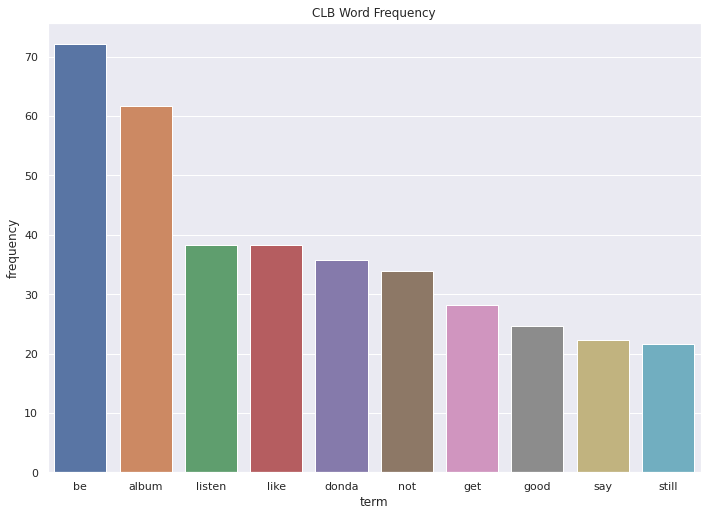

In [92]:
# Visualize frequencies
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=freq_tfidf.head(10), x='term',
            y='frequency').set_title('CLB Word Frequency')

## WordCloud


In [93]:
def create_wordcloud(tweets, max_words=500):
    """Create a wordcloud of most common words in a set of tweets"""
    
    # Transform text for WordCloud
    tweets = ' '.join(tweets)
    tweets = tweets.replace(' ', ',')
    
    # Generate wordcloud image
    figure(figsize=(10, 10), dpi=100)
    wc = WordCloud(width=600, height= 400, background_color="white", 
                   max_words=max_words)
    wc.generate(tweets)
    plt.imshow(wc, interpolation='bilinear')
    plt.title('CLB Word Cloud', size=30)
    
    plt.axis("off")

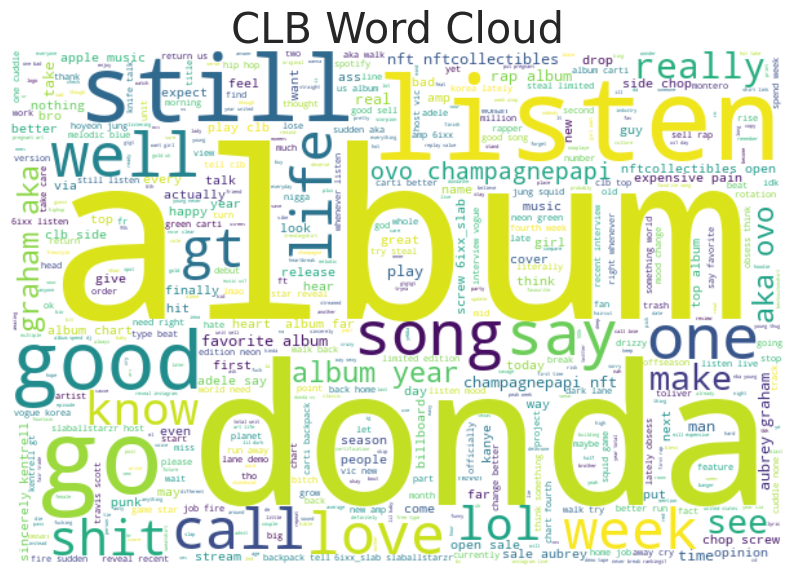

In [94]:
# Generate a wordcloud
create_wordcloud(tweet_List)